# Analysis of Log Data

## Imports and Constants

In [20]:
import io
import os
from azure.storage.blob import BlockBlobService
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
STORAGE_ACCT_NAME = os.environ.get("STORAGE_ACCT_NAME")
STORAGE_ACCT_KEY = os.environ.get("STORAGE_ACCT_KEY")
STORAGE_BLOB_NAME = os.environ.get("STORAGE_BLOB_NAME")
TRAIN_PCT = 0.80

## Load Log Data from Blob Storage

In [14]:
block_blob_service = BlockBlobService(account_name=STORAGE_ACCT_NAME, account_key=STORAGE_ACCT_KEY)
obj = block_blob_service.get_blob_to_bytes(STORAGE_BLOB_NAME, 'log_data.pkl')
x, y = joblib.load(io.BytesIO(obj.content))
print(x.shape, y.shape)

(365, 3) (365,)


## Data Visualizations

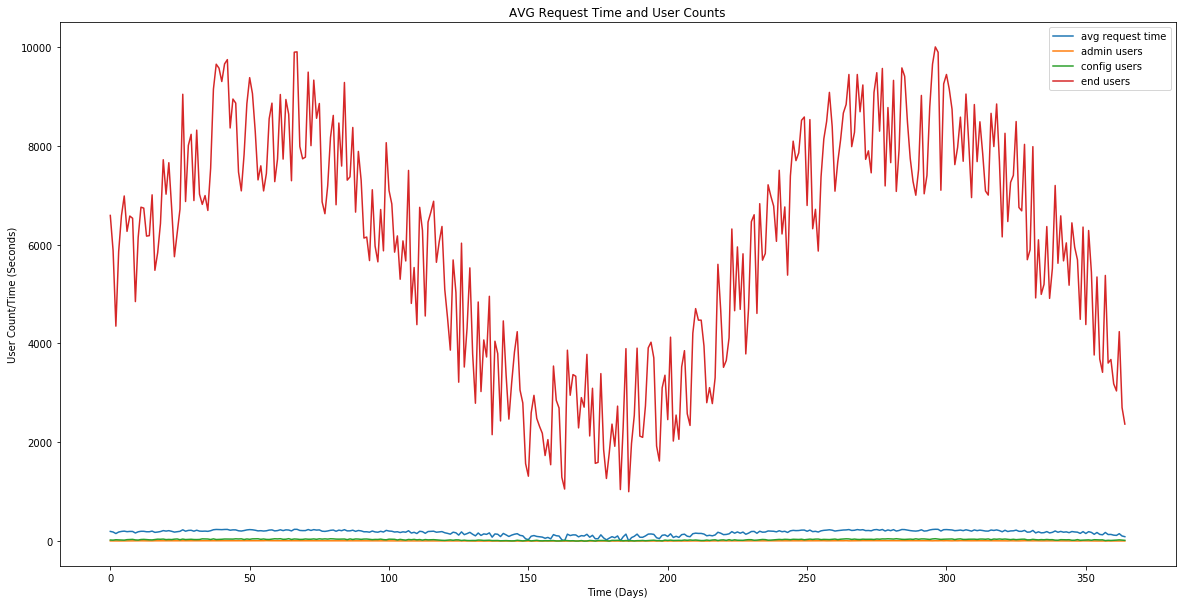

In [58]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

fig = plt.figure(figsize=(20,10))
plt.title('AVG Request Time and User Counts')
plt.xlabel('Time (Days)')
plt.ylabel('User Count/Time (Seconds)')
plt.plot(y, label='avg request time')
plt.plot([x[0] for x in x], label='admin users')
plt.plot([x[1] for x in x], label='config users')
plt.plot([x[2] for x in x], label='end users')
plt.legend()
plt.show()

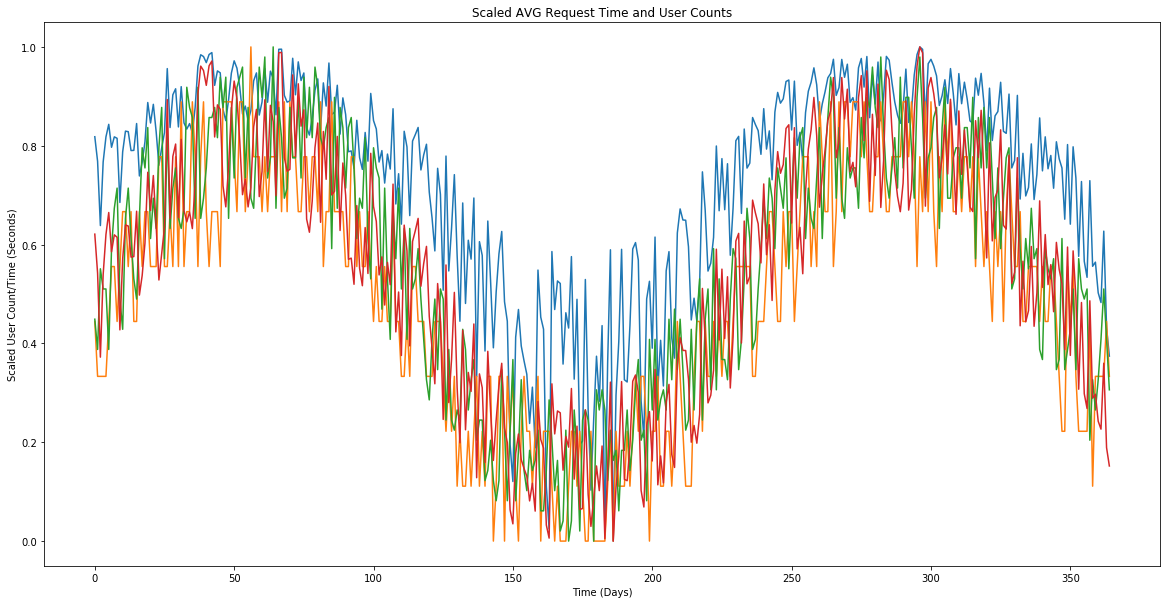

In [56]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

fig = plt.figure(figsize=(20,10))
plt.title('Scaled AVG Request Time and User Counts')
plt.xlabel('Time (Days)')
plt.ylabel('Scaled User Count/Time (Seconds)')
scaler = MinMaxScaler()
time = [y for y in y]
scaled_time = scaler.fit_transform(np.array(time).reshape((-1,1)))
plt.plot(scaled_time)
admin = [float(x[0]) for x in x]
scaled_end_users = scaler.fit_transform(np.array(admin).reshape((-1,1)))
plt.plot(scaled_end_users)
config = [float(x[1]) for x in x]
scaled_end_users = scaler.fit_transform(np.array(config).reshape((-1,1)))
plt.plot(scaled_end_users)
end = [float(x[2]) for x in x]
scaled_end_users = scaler.fit_transform(np.array(end).reshape((-1,1)))
plt.plot(scaled_end_users)
plt.show()

## Preparing Data for Algorithm

In [19]:
split_at = int(x.shape[0] * TRAIN_PCT)
x_train = x[:split_at]
x_test = x[split_at:]
y_train = y[:split_at]
y_test = y[split_at:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(292, 3) (292,) (73, 3) (73,)


## Train and Evaluate Model

In [21]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [23]:
print('R2', r2_score(y_pred, y_test))

R2 0.934136729765839


## Visually Inspect Predictions

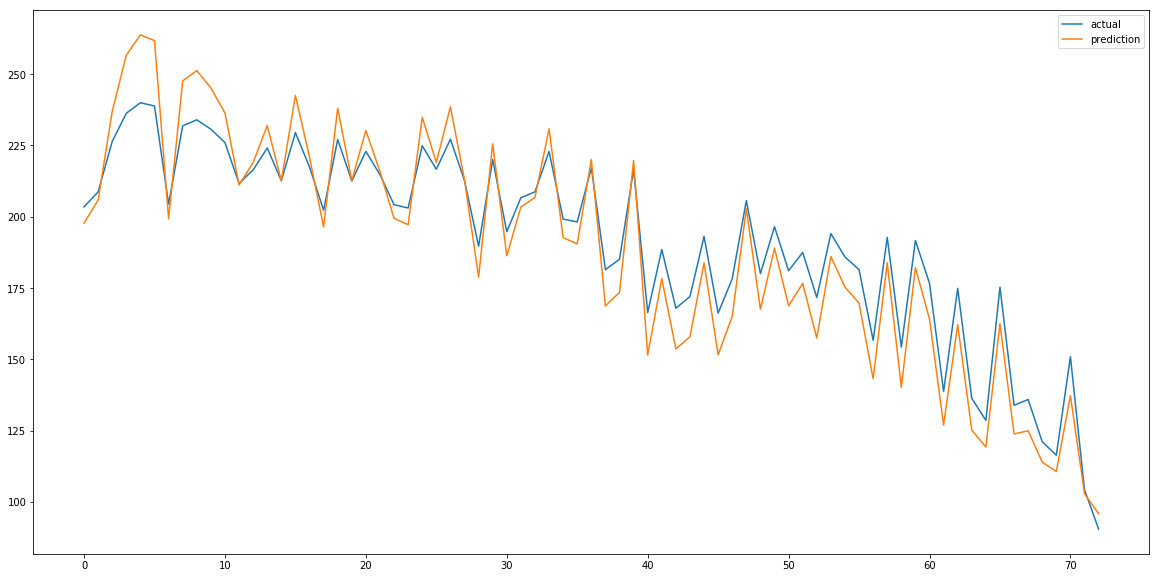

In [24]:
plt.figure(figsize=(20,10))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()